Part 1: Generate precinct-level data (merge precinct-level voting data and shapefiles).  
Part 2: Generate block-level data (merge census block-level population demographic data and shapefiles).  
Part 3: Merge voting data and population demographic data to generate final dataset at the precinct level.  

In [110]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [111]:
# Import all data files

# 2016 Harvard US House of Representatives Precinct-Level Returns
precinct_nat = pd.read_csv('../Data/harvard-2016/2016-precinct-house.csv', dtype=str, encoding='ISO-8859-1')

# 2016 NC precinct-level shapefiles: 
# https://github.com/nvkelso/election-geodata/tree/master/data/37-north-carolina/statewide/2016
precinct_geo = gpd.read_file("../Data/SBE_PRECINCTS_20160826")

# 2016 NC official district shapefiles
district_geo = gpd.read_file('../Data/shp')

# 2010 Census Summary File 1 population demographic data
block_pop = pd.read_csv('../Data/2010_Voter_Race_Data.csv')

# 2010 census block shapefiles:
block_geo = gpd.read_file('../Data/tabblock2010_37_pophu/tabblock2010_37_pophu.shp')

# Part 1

### Extract North Carolina data only from all Harvard 2016 precinct voting data.

In [112]:
precinct_nc = precinct_nat[precinct_nat['state'] == 'North Carolina']

# Generate csv with North Carolina data only
precinct_nc.to_csv('../Data/harvard-2016/harvard_nc2016_2.csv', index=False)

### Reformat Harvard voting data.

In [113]:
df = pd.read_csv("../Data/harvard-2016/harvard_nc2016_2.csv")
df["loc_prec"] = df.jurisdiction + df.precinct # Create a common identifier
summed = df.groupby(["jurisdiction", "county_fips", "loc_prec", "party"]).sum() # For each precinct, sum up all the votes for each party
# If you want to keep the district number, just add district to the list above, but not necessary.
summed.reset_index(inplace=True)

In [114]:
one_hot = pd.get_dummies(summed["party"]) # One-hot encode the party variable (i.e. create dummy variables)
summed = summed.join(one_hot)

In [115]:
# Combines data so that each precinct is represented by one row, with variables that show # of dem, rep, lib votes
summed["dem_votes"] = summed.votes * summed.democratic
summed["rep_votes"] = summed.votes * summed.republican
summed["lib_votes"] = summed.votes * summed.libertarian
final = summed.groupby(["jurisdiction", "county_fips", "loc_prec"]).sum() 
final.reset_index(inplace=True)

### Merge Harvard precinct data with precinct shapefiles

In [116]:
precinct_geo['loc_prec'] = precinct_geo.COUNTY_NAM + precinct_geo.PREC_ID

In [117]:
merged = precinct_geo.merge(final, on="loc_prec", how="outer")
eday = merged[merged.PREC_ID.notna()] # Select ONLY the "actual" precincts, not the "absentee" rows

In [118]:
# Precinct's Proportion of <party> votes out of the entire county
eday["dem_prop"] = eday["dem_votes"]/(eday.groupby("jurisdiction")["dem_votes"].transform("sum"))
eday["rep_prop"] = eday["rep_votes"]/(eday.groupby("jurisdiction")["rep_votes"].transform("sum"))
eday["lib_prop"] = eday["lib_votes"]/(eday.groupby("jurisdiction")["lib_votes"].transform("sum"))

/Users/carolyn/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carolyn/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/carolyn/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [119]:
eday['lib_votes']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2699    0.0
2700    0.0
2701    0.0
2702    0.0
2703    0.0
Name: lib_votes, Length: 2704, dtype: float64

In [120]:
# Create a new dataframe consisting ONLY of rows that represent absentee votes
absentees = pd.DataFrame(columns=merged.columns)
start_idx = merged.PREC_ID.isna().value_counts().loc[False]
for i in range(start_idx, len(merged)):
    absentees = absentees.append(merged.iloc[i])

In [121]:
# Group and sum absentee, provisional, etc. votes by precinct
ga = absentees.groupby("jurisdiction").sum().loc[:, ["dem_votes", "rep_votes", "lib_votes"]]
ga = ga.rename({'dem_votes': 'abs_dem', 'rep_votes': 'abs_rep', 'lib_votes': 'abs_lib'}, axis=1)

In [122]:
precincts = eday.merge(ga, on="jurisdiction", how = "left")

In [123]:
precincts.abs_dem.fillna(0, inplace=True)
precincts.abs_rep.fillna(0, inplace=True)
precincts.abs_lib.fillna(0, inplace=True)
precincts.lib_prop.fillna(0, inplace=True)

In [124]:
precincts["total_dem"] = precincts.dem_votes + (precincts.dem_prop * precincts.abs_dem)
precincts["total_rep"] = precincts.rep_votes + (precincts.rep_prop * precincts.abs_rep)
precincts["total_lib"] = precincts.lib_votes + (precincts.lib_prop * precincts.abs_lib)
precincts["total_votes"] = precincts.total_dem + precincts.total_rep + precincts.total_lib

### Verify precinct level data.

/Users/carolyn/opt/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


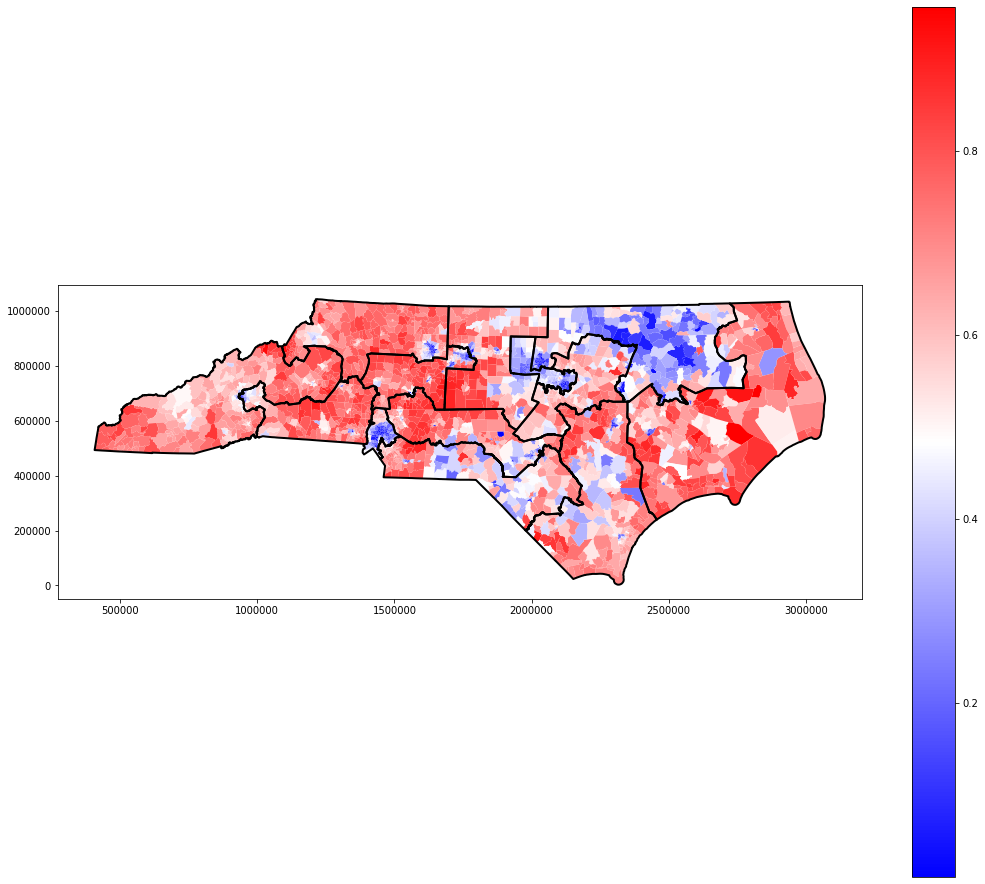

In [125]:
precincts['dem_percent'] = precincts.total_dem/precincts.total_votes
precincts["rep_percent"] = precincts.total_rep/precincts.total_votes

district_geo = district_geo.to_crs(precincts.crs)
base = precincts.plot(column="rep_percent", cmap = "bwr", legend=True, figsize=(18, 16))
district_geo.plot(ax=base,edgecolor='black', linewidth = 2, facecolor="none")

In [126]:
# For each district, calculate the intersection between that district and all precincts. 
# If the intersection area is at least 50% of the precinct's total area, classify it as being in that district
precincts["district"] = 0
for i in range(len(district_geo)):
    district = district_geo.iloc[i, 1]
    areas = (precincts.intersection(district)).area/precincts.area
    precincts.loc[areas>0.5, "district"] = district_geo.iloc[i].loc["District"]

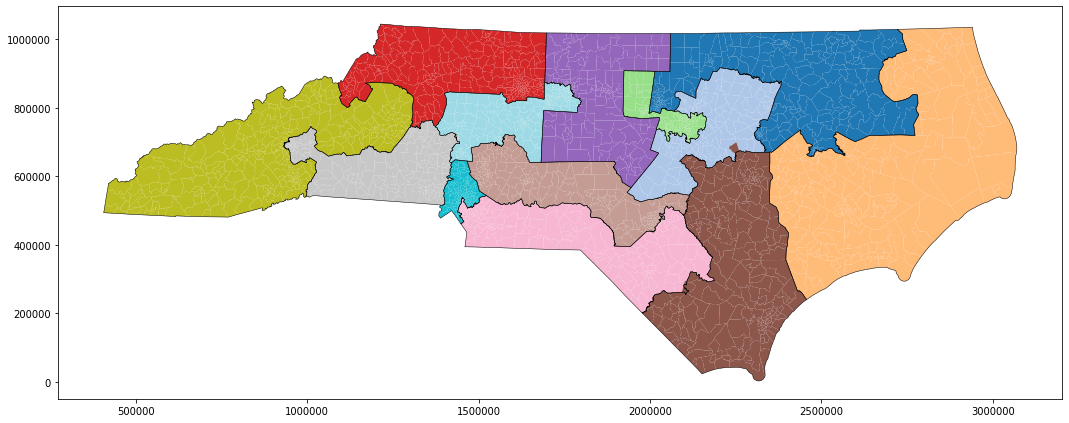

In [127]:
base = precincts.plot(column="district", figsize=(18, 16), cmap="tab20")
district_geo.plot(ax=base,edgecolor='black', linewidth = 0.5, facecolor="none")

In [128]:
# Check that votes in each district add up!

print("#", "Dem Votes", "Rep Votes", "Total Votes")
# Note that district 0 technically has some votes... because not all precincts may be classified into districts correctly.
for i in range(0, 13):
    dist_dem_votes = precincts.loc[precincts.district == i+1, "total_dem"].sum().round()
    dist_rep_votes = precincts.loc[precincts.district == i+1, "total_rep"].sum().round()
    dist_total_votes = precincts.loc[precincts.district == i+1, "total_votes"].sum().round()
    num_precincts = len(precincts.loc[precincts.district == i+1, "total_votes"])
    print(i+1, dist_dem_votes, dist_rep_votes, dist_total_votes)

# Dem Votes Rep Votes Total Votes
1 245339.0 102691.0 356495.0
2 159547.0 211131.0 370685.0
3 103821.0 215392.0 319213.0
4 283975.0 135395.0 419370.0
5 147922.0 207716.0 355638.0
6 143176.0 208005.0 351181.0
7 138634.0 218612.0 357246.0
8 133563.0 189930.0 323493.0
9 137379.0 192225.0 329604.0
10 129014.0 222465.0 351479.0
11 129532.0 229659.0 359191.0
12 235506.0 115844.0 351350.0
13 155253.0 198262.0 353515.0


### Add adjacent precincts to precinct data as additional column

In [129]:
# Takes about 1 minute
for index, row in precincts.iterrows():  
    neighbors = precincts[precincts.geometry.touches(row['geometry'])].loc_prec.tolist() 
    precincts.at[index, "my_neighbors"] = ", ".join(neighbors)

In [130]:
# Write fully processed precinct-level data to file with_adjacent
# precincts.to_file("../Data/with_adjacent.shp")

# Part 2

### Reformat block-level shapefile data to match population data

In [131]:
# unique block identifier is the 'BLOCKID10' column for df and the 'GEOID' column for population data (pf)
block_geo = block_geo.rename(columns={'BLOCKID10': 'GEOID'}) # rename the 'BLOCKID10' column to 'GEOID' for df
block_geo['GEOID'] = block_geo.GEOID.astype('int64') # match data type of 'GEOID' column between datasets

### Merge block-level population and shapefile data

In [132]:
merged = block_geo.merge(block_pop, on='GEOID')

### Reformat county FIPS codes ('COUNTYFP10' column) in merged block-level data

In [133]:
merged['COUNTYFP10'] = merged.COUNTYFP10.astype('int64')
merged['COUNTYFP10'] += 37000

In [134]:
# Write merged block-level data into new file
blocks = merged
# blocks.to_file('../Data/census_county3/census_county3.shp')

# Part 3

The final version of the precinct-level data is 'precincts'. The final version of the block-level data is 'blocks'.

In [135]:
# County id processing for precinct data
precincts.loc[precincts.county_fips.isna(), "county_fips"] = 37125 #EDITED COUNTY_FIP TO COUNTY_FIPS
precincts.county_fips = precincts.county_fips.astype('int64') - 37000

In [136]:
# Match coordinate reference systems
blocks = blocks.to_crs(precincts.crs)

In [137]:
# Use centroids for blocks
blocks['geometry'] = blocks['geometry'].centroid

In [138]:
# Merge blocks and precincts 
merged = gpd.sjoin(blocks, precincts, how='right', op='within')

In [139]:
# Rename census codes to make them more readable
merged = merged.rename(columns={'POP10':'total_pop','P0110001': 'total_18+', 'P0110002': 'hispanic', 'P0110003': 'not_hispanic', 'P0110004': 'pop_1_race',
                'P0110005': 'white','P0110006': 'african_am',
            'P0110007': 'am_indian_native', 'P0110008': 'asian', 'P0110009':'hawaii/pac_is', 'P0110010':'other_race_alone', 'P0110011':'2+races'})

In [140]:
# Drop some unnecessary/duplicated columns
# EDITED COLUMN NAMES
dataset = merged.drop(columns=["GEOID", "SUMLEV", "STATE", "COUNTY", "TRACT", "BLOCK", "PREC_ID", 
                               "ENR_DESC", "OF_PREC_ID", "COUNTY_ID", "jurisdiction", "county_fips", 
                               "year", "state_fips", "state_icpsr", "county_ansi", "county_lat", "county_long", "candidate_govtrack", 
                               "candidate_icpsr", "candidate_maplight", "democratic", "libertarian", "republican", "index_left"])

In [141]:
# Extract precinct-level demographics from merged precinct-block data
extract_demographics = (dataset.groupby(["loc_prec"]).sum()).loc[:,"HOUSING10":"2+races"]
extract_demographics.reset_index()

,loc_prec,HOUSING10,total_pop,total_18+,hispanic,not_hispanic,pop_1_race,white,african_am,am_indian_native,asian,hawaii/pac_is,other_race_alone,2+races
0,ALAMANCE01,2095,4869,3686,79,3607,3588,3309,257,8,8,1,5,19
1,ALAMANCE02,1958,4491,3483,40,3443,3428,3321,81,17,9,0,0,15
2,ALAMANCE035,2188,6581,5753,169,5584,5524,4991,445,16,62,0,10,60
3,ALAMANCE03C,1178,2814,2153,44,2109,2093,1884,148,1,57,0,3,16
4,ALAMANCE03N,1790,4966,4228,94,4134,4089,3661,343,1,77,3,4,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2699,YANCEY07 BRU,337,554,441,8,433,431,429,1,1,0,0,0,2
2700,YANCEY08 CRA,1655,3359,2653,68,2585,2576,2559,5,4,8,0,0,9
2701,YANCEY09 SOU,1660,2344,1894,46,1848,1834,1817,11,4,2,0,0,14
2702,YANCEY10 PEN,572,625,528,11,517,514,513,1,0,0,0,0,3


In [142]:
# Merge precinct-level demographic data with original precinct files (we don't need block data anymore)
final = precincts.merge(extract_demographics, how="inner", on="loc_prec")
final = final.drop(columns=["PREC_ID", 
                               "ENR_DESC", "OF_PREC_ID", "COUNTY_ID", "jurisdiction", "county_fips", 
                               "year", "state_fips", "state_icpsr", "county_ansi", "county_lat", "county_long", "candidate_govtrack", 
                               "candidate_icpsr", "candidate_maplight", "democratic", "libertarian", "republican"])

In [143]:
# Check requirements for #3, that total district populations add up
final[["total_pop", "district"]].groupby("district").sum()

,total_pop
district,
1,733323
2,732642
3,732604
4,733225
5,733866
6,733554
7,736412
8,735286
9,731495


In [144]:
# Check requirements for problem 3, that voting results match published results
final[["total_dem", "total_rep", "total_votes", "district"]].groupby("district").sum()

,total_dem,total_rep,total_votes
district,,,
1,245339.364342,102690.590238,356494.657167
2,159547.254068,211131.191994,370684.743476
3,103820.941901,215392.257953,319213.199854
4,283975.100742,135394.523131,419369.623872
5,147921.833940,207716.144386,355637.978326
6,143175.849235,208005.286881,351181.136116
7,138634.077053,218611.787450,357245.864502
8,133562.625680,189930.005971,323492.631651
9,137378.594120,192225.081909,329603.676029


In [145]:
# Add column with total minority voting age population
final['minority'] = final['total_18+']-final['white']

In [146]:
# final.to_file("../Data/cen_prec_data3.shp")